# Введение

В ходе работы необходимо проанализировать данные по оттоку клиентов из сети фитнес центров, а так же подговоить план по их удержанию: 
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные  свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

## Содержание

* [Загрузка исходных данных.](#link1)
* [Исследовательский анализ данных](#link2)
* [Построение моделей прогнозирования оттока пользователей](#link3)
* [Кластеризация пользователей](#link4)
* [Вывод](#link5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
%autosave 60

Autosaving every 60 seconds


## <a id="link1">Загрузка исходных данных</a>

Загрузим исходные данные и изучим общую информацию по ним:

In [2]:
gym_data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_data.duplicated().sum()

0

Приведем столбцы к нижнему регистру:

In [5]:
gym_data.columns = map(str.lower, gym_data.columns)

In [6]:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Датасет содержит в себе записи о данных 4000 клиентов фитнес-центров. Данные содержат в себе только целочисленные и вещественные величины, строковые переменные в данных отсутствуют. Часть данных представлена в бинарном виде.

gender - пол клиента, в дальнейшем будем считать значение этого параметра равным 1 - мужской пол, 0 - женский

near_location - проживание или работа в районе, где находится фитнес-центр

partner - сотрудник компании-партнёра клуба

promo_friends - факт первоначальной записи в рамках акции «приведи друга»

phone - наличие контактного телефона

age - возраст

lifetime - время с момента первого обращения в фитнес-центр (в месяцах)

contract_period - длительность текущего действующего абонемента 

month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)

group_visits — факт посещения групповых занятий

avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента

avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц

avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра

Все величины представлены оптимальными типами данных, преобразовани их не требуется, пропусков в данных не обнаружено. 

Проверим данные на дубликаты:

In [7]:
gym_data.duplicated().sum()

0

Дубликатов так же не обнаружено, предобработка данных не требуется, можно переходить к исследовательскому анализу.

## <a id="link2">Исследовательский анализ данных</a>

Посмотрим на описательную статистику исходного набора данных:

In [8]:
gym_data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


На основе описательной статистики мы видим, что данные не содержат каких-то выбросов, стандартное вещественных величин отклонение не превышает среднее значение. Можно заметить, что в исходном наборе данных клиенты по гендерному признаку поделены примерно поровну; преобладают те, кто живет или работает рядом с фитнес-центром; около половины клиентов - работники компаний-партнеров; по промо акции "приведи друга" пришли только 30%; средняя длительность абонемента 4,6 мес; средний возраст клиентов - 29 лет; средняя "продолжительность жизни" клиентов 3,7 мес; средняя посещаемость около 1,8 раз в неделю.

Разделим исходный набор данных на тех клиентов, кто остался в текущем месяце в финтесс-клубе, и тех, кто его покинул:

In [9]:
keeped_clients = gym_data.query('churn == 0').drop('churn', axis = 1)
lost_clients = gym_data.query('churn == 1').drop('churn', axis = 1)

Построим графики распределения и столбчатые диаграммы признаков для тех клиентов, кто покинул фитнесс-центр и тех, кто остался:

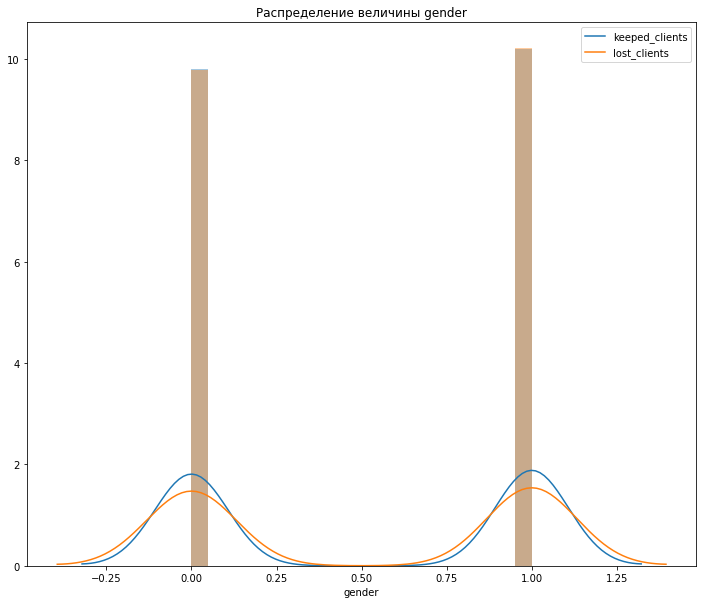

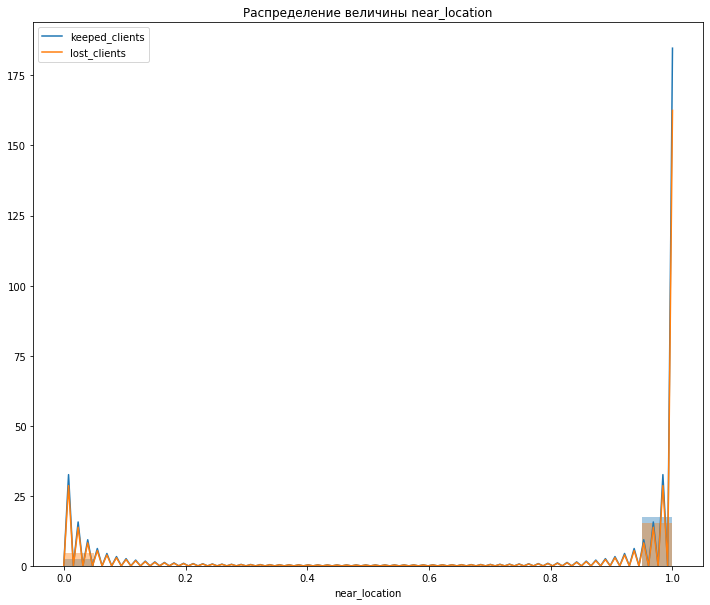

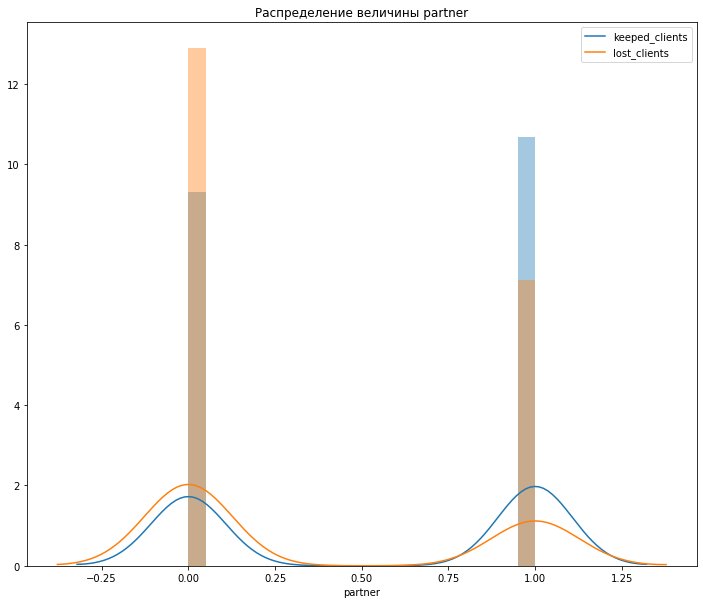

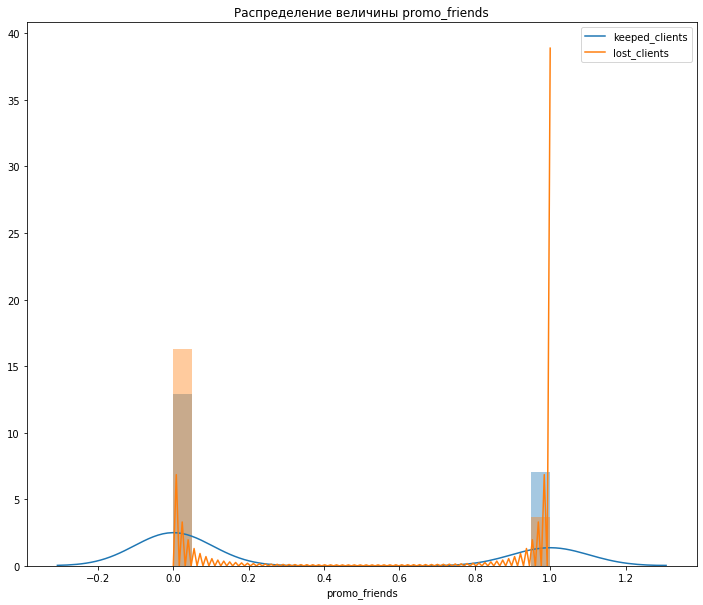

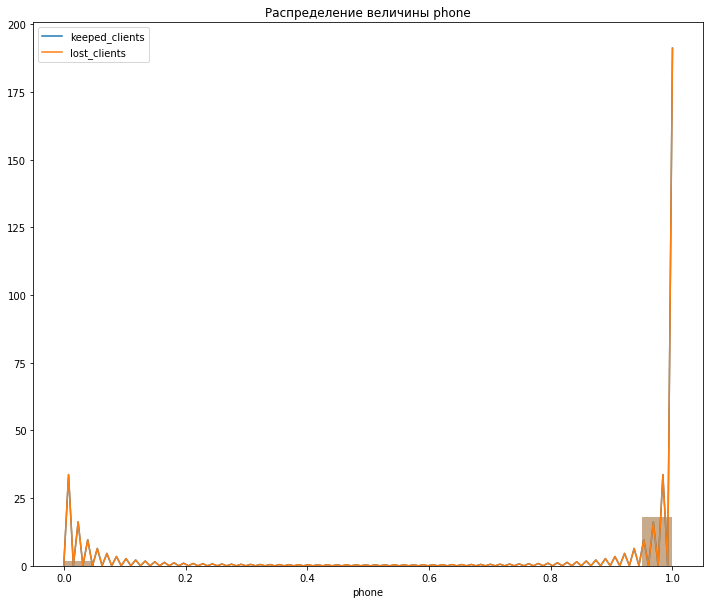

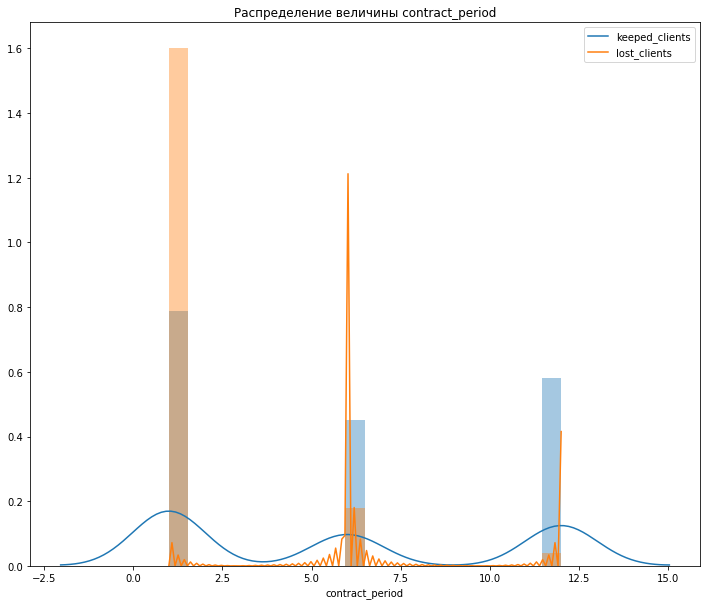

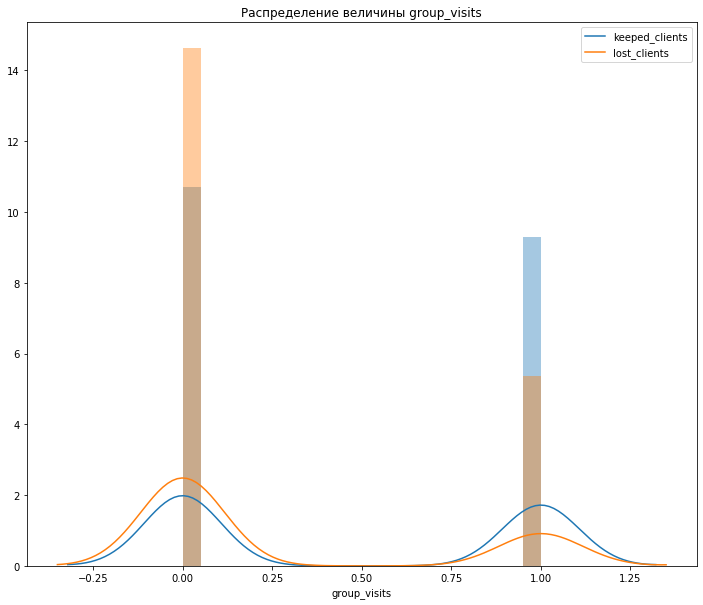

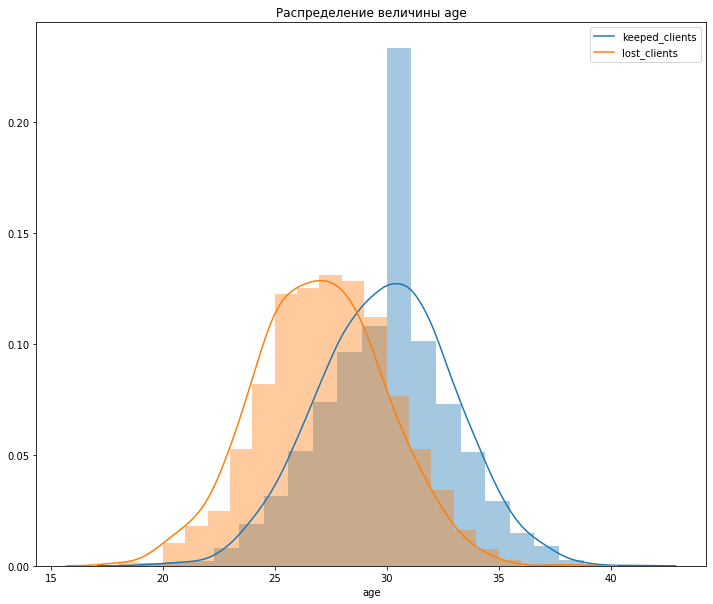

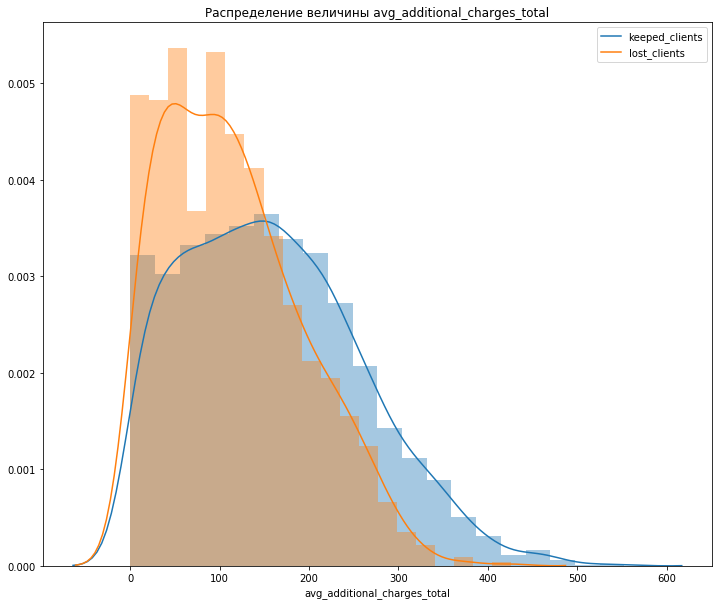

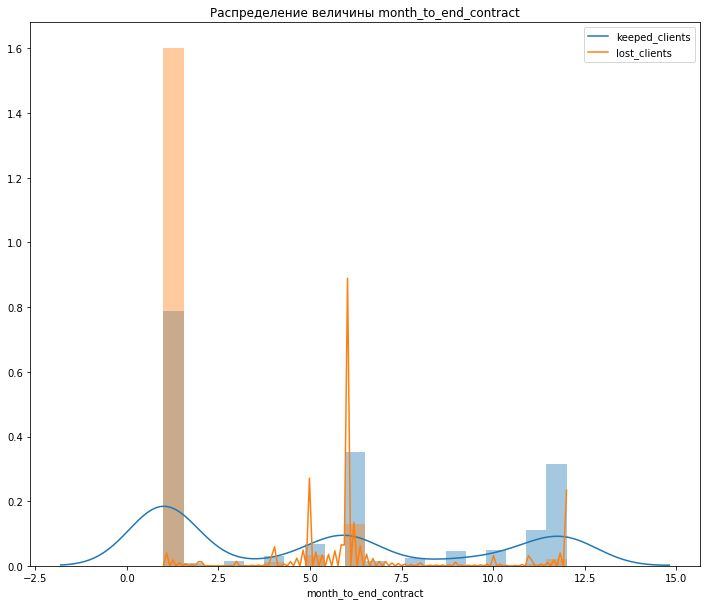

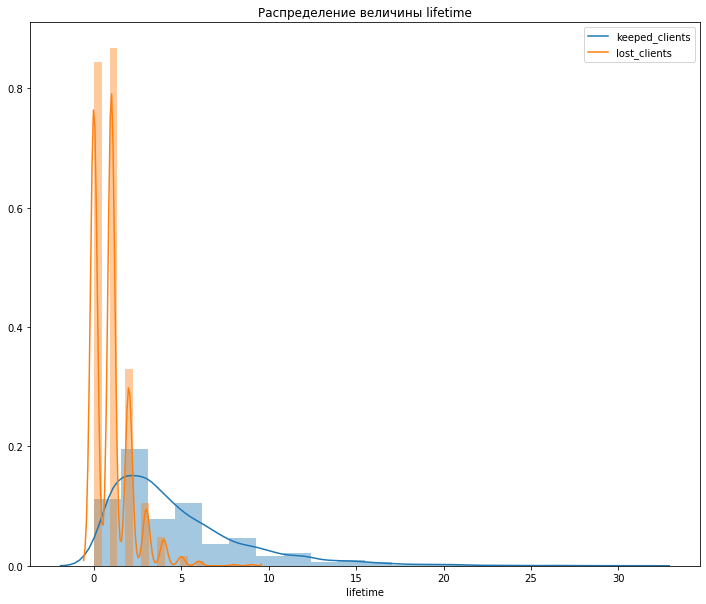

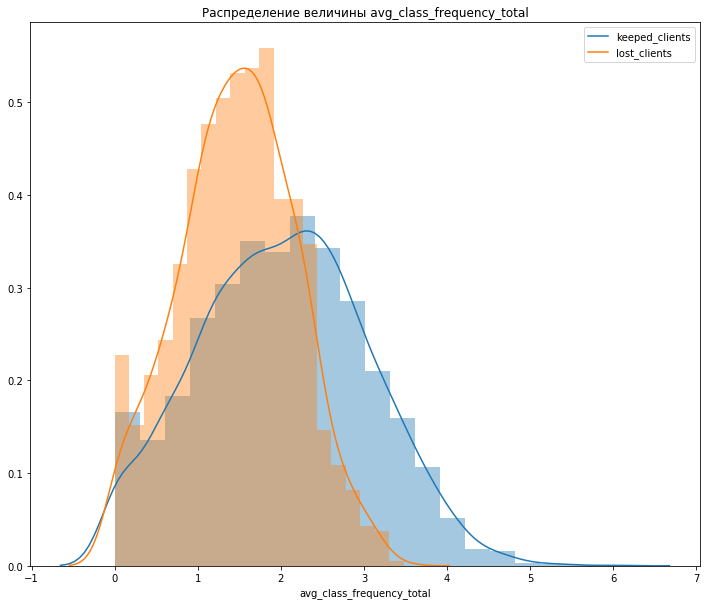

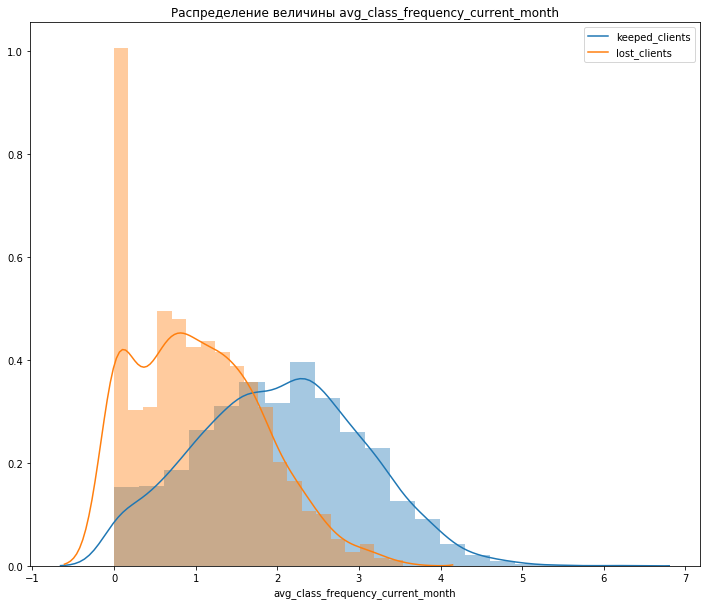

In [10]:
for i in lost_clients.columns:
    
    plt.figure(figsize=(12,10))
    
    sns.distplot(keeped_clients[i], bins = 20,  kde_kws = {'label':'keeped_clients'})
    
    sns.distplot(lost_clients[i], bins = 20, kde_kws = {'label':'lost_clients'})
    
    plt.title('Распределение величины {}'.format(i))
    
    plt.show()

Взглянем на средние значения признаков, ушедших и оставшихся клиентов:

In [11]:
gym_data.groupby('churn').agg({'mean'}).T

,churn,0,1
gender,mean,0.510037,0.510839
near_location,mean,0.873086,0.768143
partner,mean,0.534195,0.355325
promo_friends,mean,0.353522,0.183789
phone,mean,0.903709,0.902922
contract_period,mean,5.747193,1.728558
group_visits,mean,0.464103,0.268615
age,mean,29.976523,26.989632
avg_additional_charges_total,mean,158.445715,115.082899
month_to_end_contract,mean,5.283089,1.662582


Опираясь на графики и средние значения признаков, можно говорить о том, что в среднем фитнес-клуб покидают люди, которые реже оказываются сотрудниками компаний-партнеров, реже живут или работают рядом с клубом, реже приходят по рекомендации друзей, так же эта группа оказывается в среднем моложе тех ( 27 лет против 30 лет), кто остается в клубе. Дополнительнгые затраты клиентов, которые покидают клуб, на 25% ниже, чем затраты тех, кто продолжает ходить. Абонементы тех, кто уходит, в среднем в 3 раза меньше по времени и в 3 раза быстрее заканчиваются, чем у тех, кто продолжает пользоваться услугами фитнес-центров. Отдельно стоит отметить, что клиенты, которые уходят, занимаются непродолжительное время, их "лайфтайм" в среднем всего около 1 месяца, посещают клуб они в 2 раза реже тех, кто остается клиентом, т.е в среднем 1 раз в неделю в текущем месяце.

Выведем матрицу корреляции, между всеми признаками и целевой величиной:

In [12]:
gym_data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


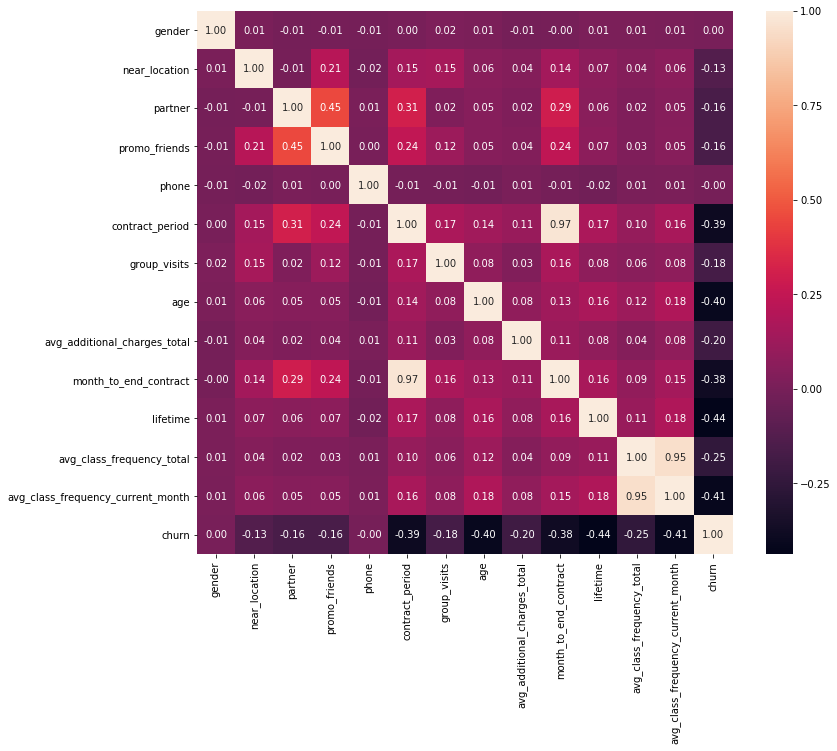

In [13]:
plt.figure(figsize=(12,10))

sns.heatmap(gym_data.corr(), annot=True, fmt=".2f")

sns.set(rc={'figure.figsize':(10,10)})

Согласно коэффициентам корреляции, целевая величина имеет самую большу зависимость от следующих параметров: 
возраст, лайфтайм, количество месяцев до конца абонемента, длительность текущего абонемента, средняя частота посещения центра  в текущем месяце. Все эти признаки имеют коэффициент обратной связи около 0,4 с целевой переменной, зависимость целевой переменной от остальных признаков выражена в меньшей степени.

Так же по результатам изучения матрицы корреляции, можно заметить сильную прямую связь между двумя парами признаков: avg_class_frequency_total и avg_class_frequency_current_month, month_to_end_contract и contract_period, корреляция внутри пар признаков более 0,8. Такая сильная прямая линейная связь между признаками может оказать серьезное влияние на работу нашей будущей модели, модель переобучится и будет плохо работать на реальных данных, следовательно нужно избавиться от мультиколлинеарности. Уберем те признаки, которые имеют меньшую связь с целевой переменной.

In [14]:
gym_data_upd = gym_data.drop(['avg_class_frequency_total','month_to_end_contract'] , axis = 1)

### <a id="link3">Построение моделей оттока пользователей</a>

Разделим исходный датасет на целевую переменную и признаки:

In [15]:
x = gym_data_upd.drop('churn', axis = 1)

y = gym_data_upd['churn']

Воспользуемя методом train_test_split для разделения исходных данных на обучающую и валидационную выборку в соотношении 80/20:

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Перед построение моделей стандартизируем данные, это позволит улучшить конечные результаты, ранее мы заметили, что не все метрики имеют вид нормального распределения:

In [17]:
scaler = StandardScaler()

scaler.fit(x_train)

x_train_st = scaler.transform(x_train)

x_test_st = scaler.transform(x_test)

В качестве первой модели построим модель логистической регресии:

In [18]:
model1 = LogisticRegression(random_state=0, solver = 'lbfgs')

Обучим модель на стандартизированных данных:

In [19]:
model1.fit(x_train_st, y_train);

Построим прогноз модели на основании данных валидационной выборки:

In [20]:
predictions1 = model1.predict(x_test_st)

Рассчитаем метрики accuracy, precision и recall_score для полученных значений целевой переменной на выходе модели:

In [21]:
print('Метрика Accuracy для модели логистической регресии',accuracy_score(y_test, predictions1).round(5))

print('Метрика Precision для модели логистической регресии',precision_score(y_test, predictions1).round(5))

print('Метрика Recall для модели логистической регресии',recall_score(y_test, predictions1).round(5))

Метрика Accuracy для модели логистической регресии 0.9025
Метрика Precision для модели логистической регресии 0.79126
Метрика Recall для модели логистической регресии 0.82323


Полученные метрики указывают на то, что модель логистической регрессии с вероятностью 0,9025 правильно определяет будущее клиента в следующем месяце правильно, при этом определяет среди всех положительных (тех, кто уйдет) ответов долю верных в размере 0,79126, так же верно моделью верно идентифицируется доля 0.82323 от всех уходящих клиентов.

В качестве следующей модели будем использовать алгоритм случайного леса:

In [22]:
model2 = RandomForestClassifier(n_estimators = 100, random_state = 0)

Обучим модель на стандартизированной тестовой выборке:

In [23]:
model2.fit(x_train_st, y_train);

Построим прогноз на основании тестового набора данных:

In [24]:
predictions2 = model2.predict(x_test_st)

Рассчитаем метрики accuracy, precision и recall_score для полученных значений целевой переменной на выходе модели:

In [25]:
print('Метрика Accuracy для модели случайного леса',accuracy_score(y_test, predictions2).round(5))

print('Метрика Precision для модели случайного леса',precision_score(y_test, predictions2).round(5))

print('Метрика Recall для модели случайного леса',recall_score(y_test, predictions2).round(5))

Метрика Accuracy для модели случайного леса 0.895
Метрика Precision для модели случайного леса 0.81319
Метрика Recall для модели случайного леса 0.74747


В свою очеред модель случайного леса, показывает чуть меньшую точность прогнозов в общем, чем модель логистической регресии - доля ее верных прогнозов 0,895, доля верных прогнозов среди всех, определенных уходящими клиентами - 0.81319, а доля истинно уходящих клиентов 0.74747.

По итогам изучения полученных метрик, для двух построенных моделей, стоит отдать предпочтение модели логистической регрессии, так как при общей большей точности, она еще и точнее определяетс долю истинно уходящих клиентов. Следовательно, пользуясь этой моделью, бизнес сможет приняться меры по удержанию большего числа собирающихся уйти, что положительно скажется на количестве тех, кого удалось удержать.

### <a id="link4">Кластеризация пользователей</a>

Произведем кластеризацию всех пользователей на основе исходного датасета, но перед этим сначала стандартизируем данные:

In [26]:
x_sc = scaler.fit_transform(gym_data.drop('churn', axis = 1))

Рассчитаем расстояния между наборами признаков для каждого клиентам:

In [27]:
linked = linkage(x_sc, method = 'ward')

Построим дендограмму:

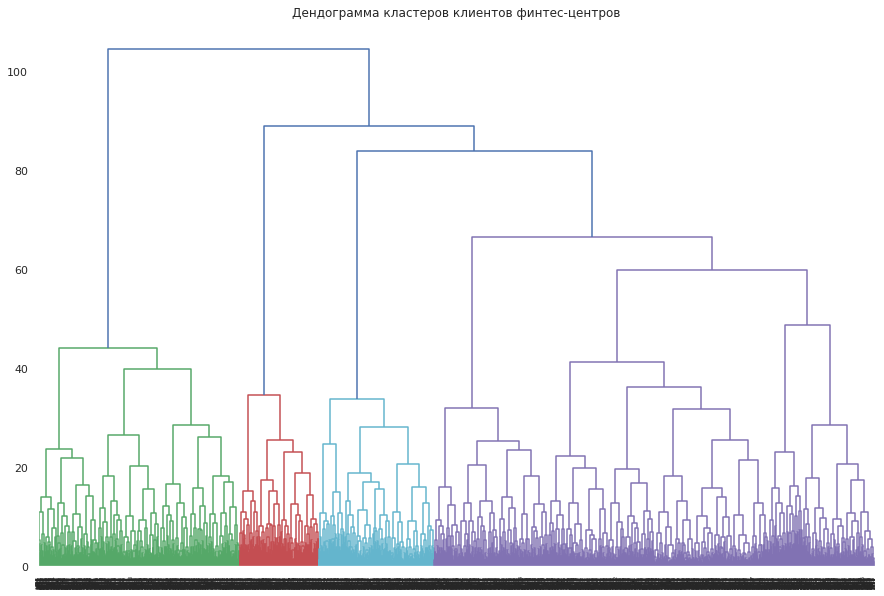

In [35]:
plt.figure(figsize=(15, 10))

dendrogram(linked, orientation='top')

plt.title('Дендограмма кластеров клиентов финтес-центров')

plt.show()

На основании визуального изучения дендограммы, для решения задачи кластеризации можно выделить от 4 до 6 значимых крупных кластеров клиентов. По условиям задания выберем их количество равным 5.

Для кластеризации пользователей будем использовать метод K-Means, который пошагово группирует объекты и минимизирует среднее расстояние от объектов до центра кластера:

In [29]:
km = KMeans(n_clusters = 5, random_state=0)

labels = km.fit_predict(x_sc)

Запишем полученные кластеры в исходный датасет:

In [30]:
gym_data['cluster'] = labels

Выведем средние значения всех переменных с группировкой по кластерам пользователей:

In [31]:
gym_data.groupby('cluster').agg('mean').T

cluster,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


А так же выведем абсолютное число клиентов в кластере и их долю от общего числа клиентов:

In [32]:
gym_data.groupby('cluster')['gender'].count()

cluster
0    1011
1     385
2     505
3    1262
4     837
Name: gender, dtype: int64

In [33]:
gym_data.groupby('cluster')['gender'].count()/gym_data.shape[0]

cluster
0    0.25275
1    0.09625
2    0.12625
3    0.31550
4    0.20925
Name: gender, dtype: float64

Посмотрим графики диаграмм размаха признаков целевой величины в зависимости от кластера:

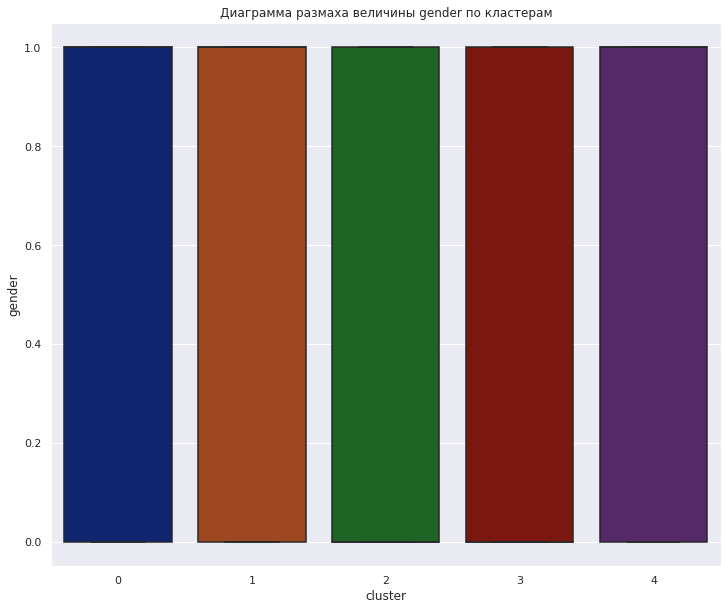

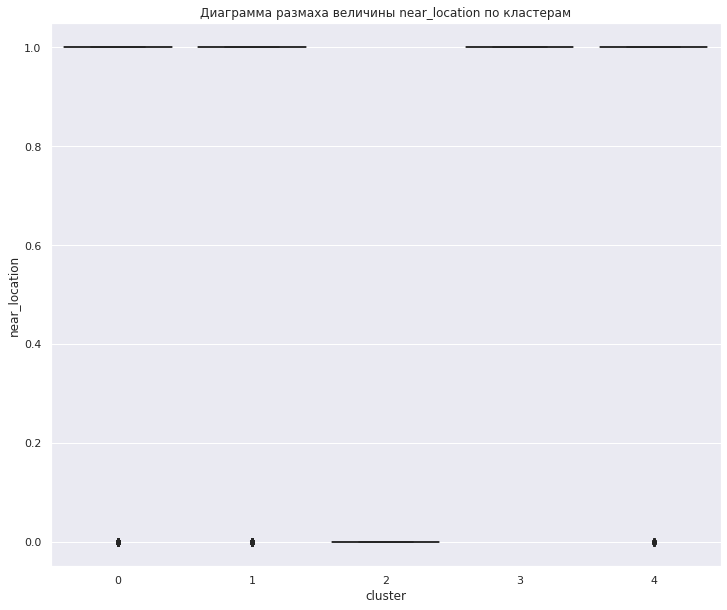

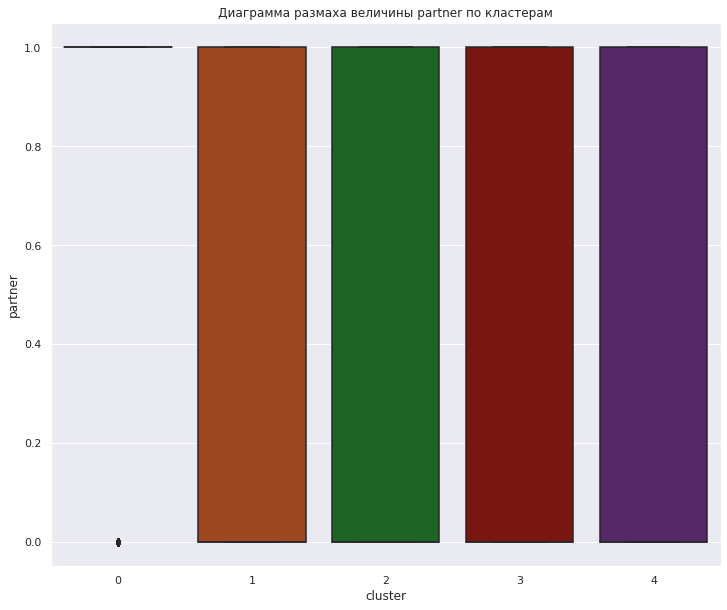

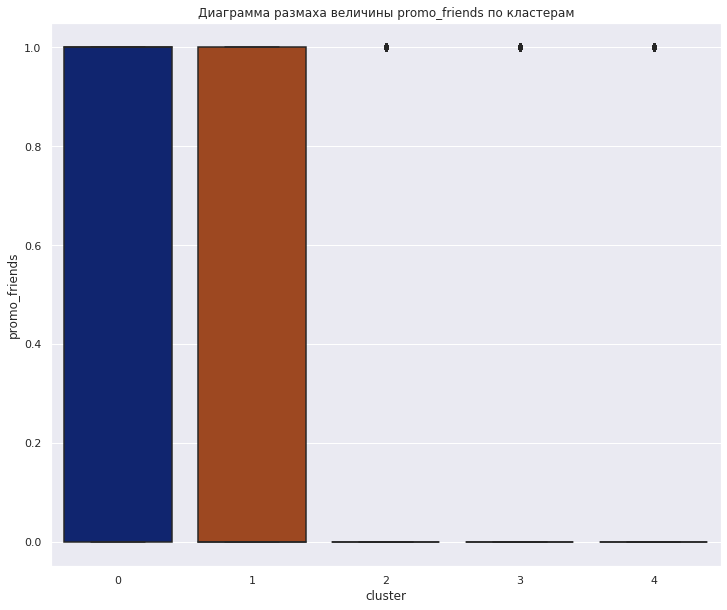

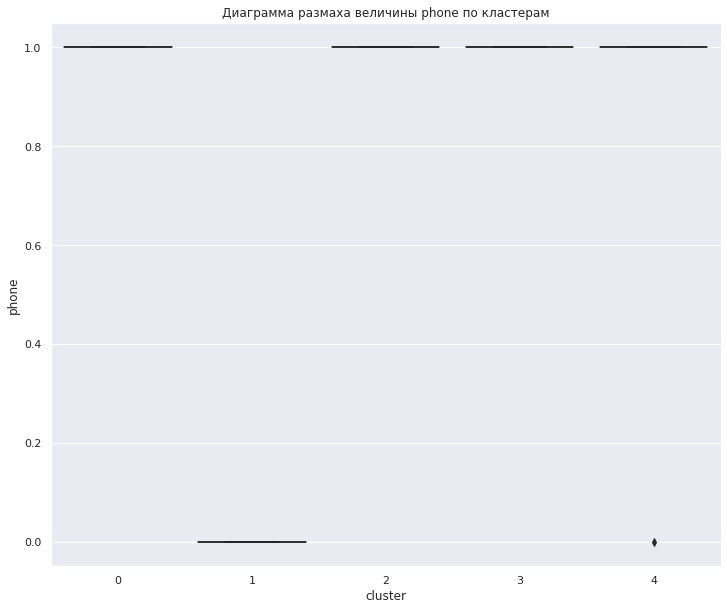

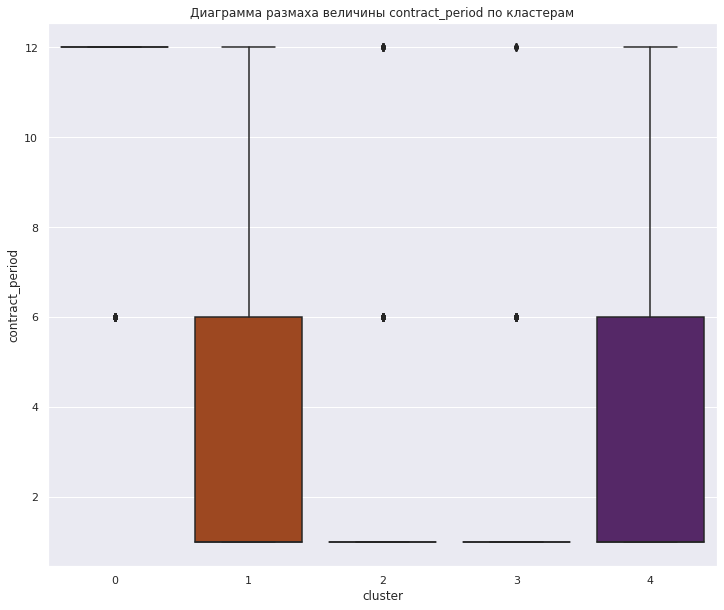

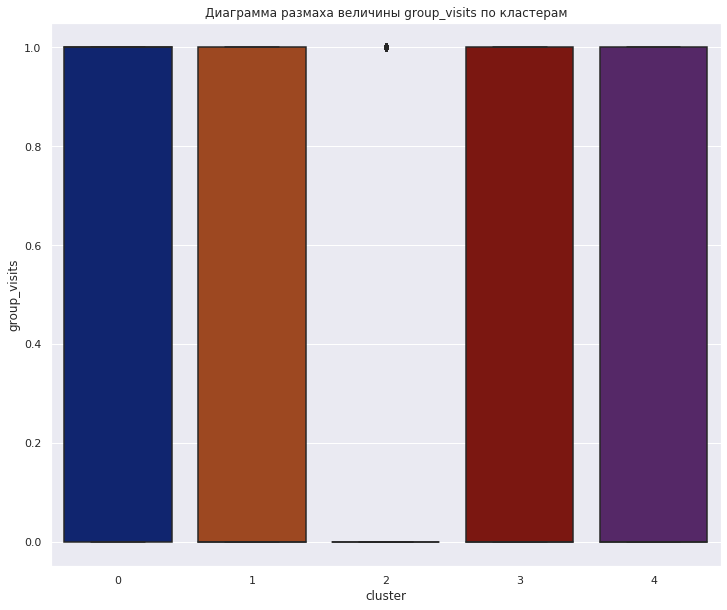

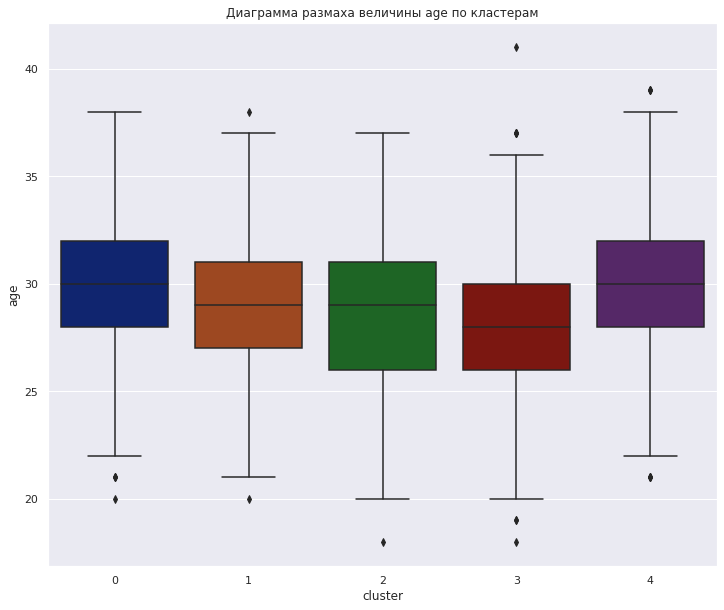

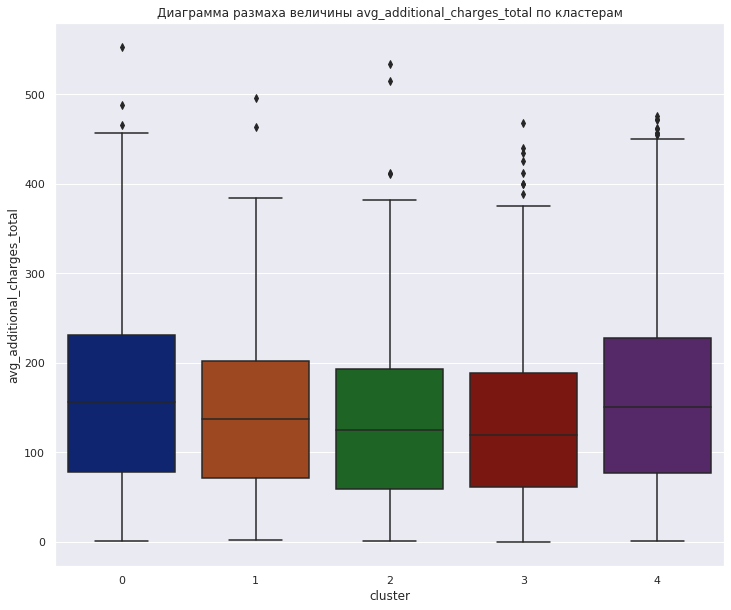

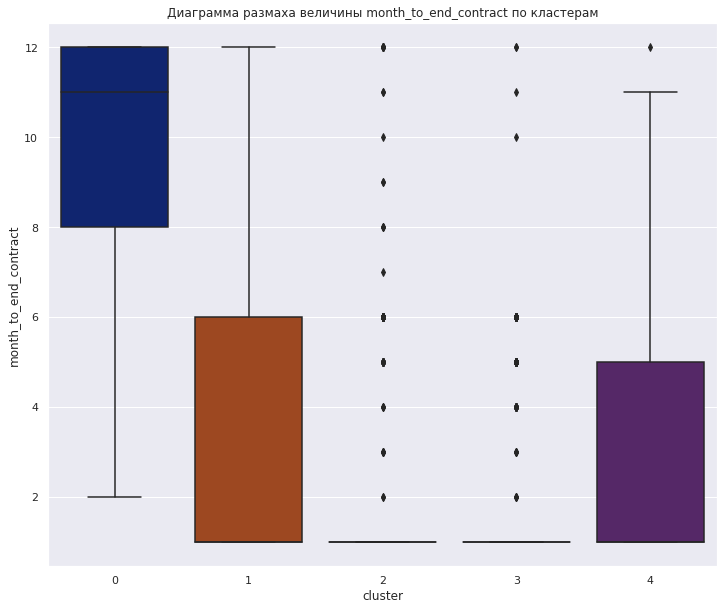

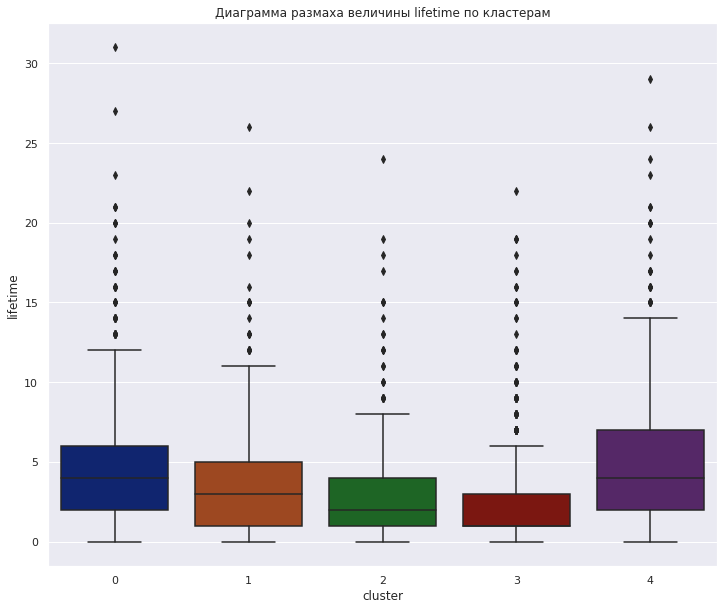

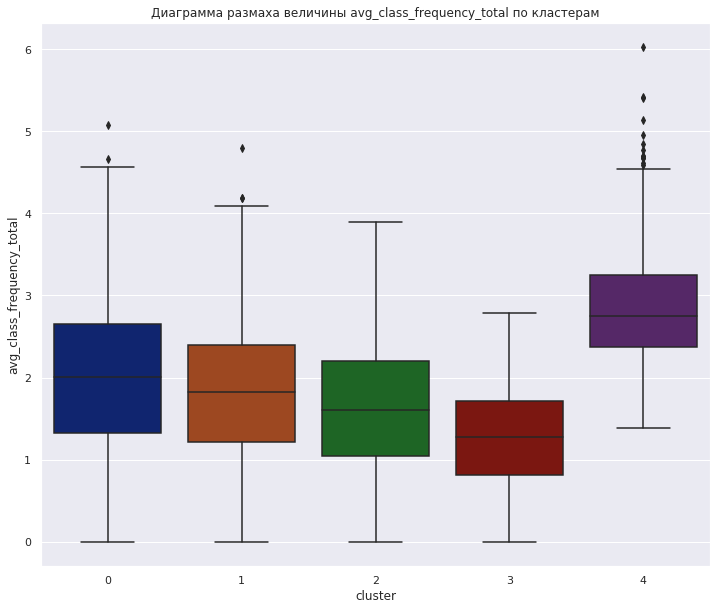

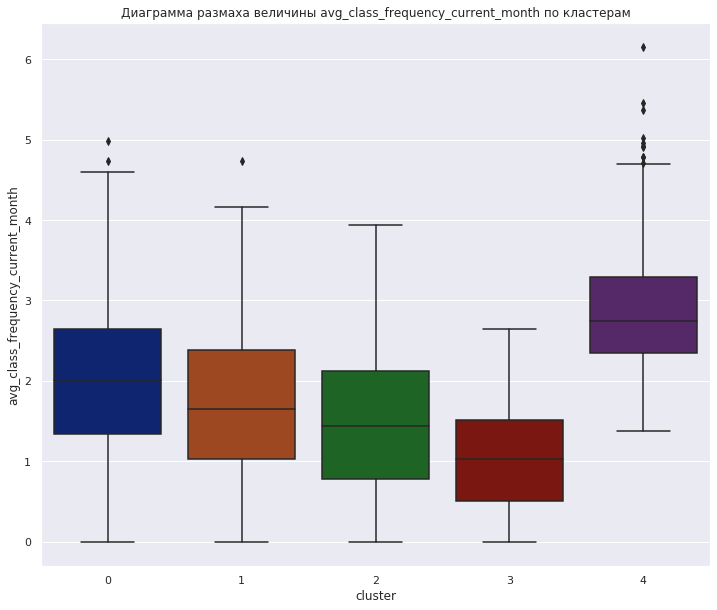

<Figure size 864x720 with 0 Axes>

In [34]:
for i in gym_data.drop('churn', axis = 1).columns:
    
    plt.figure(figsize=(12,10))
    
    if i != 'cluster':
        
        plt.title('Диаграмма размаха величины {} по кластерам'.format(i))
        
        sns.boxplot(x = gym_data.cluster, y = gym_data[i], palette = 'dark');
        
    plt.show()


На основании диаграмм размаха и средних значений признаков, можно составить портрет клиента каждого кластера:

Киленты нулевого кластера это примерно по ровну женщины и мужчины, преимущественно проживающие или работающие рядом с клубом, которые, как правило, являются сотрудниками организации-парнера. Они довольно часто, в 57% случаев, приходят по рекомендации друзей. Они имеют долгосрочный абонемент, 11 месяцев в среднем, время до окончания их абонемента около 10 месяцев, средний возраст таких клиентов около 30 лет. Они совершают достаточно много дополнительных трат в клубе, около 161 у.е,чаще других кластеров посещяют групповые занятия. В среднем такие клиенты посещали финтес-клуб, около 2 раз в неделю, как в последнем месяце, так и в целом. Лайфтайм клиентов данного кластера составляет 4.7 месяцев. Всего лишь 2% таких клиентов, покидуют клуб в следующем месяце, это самый низкий показатель среди кластеров. Доля таких клиентов в финтес-центре составляет около 25%.

Клиенты первого кластера, в среднем на 4% больше представлены мужским полом, 86% из которых живут или работают рядом с финтес-клубом. Такие клиенты в 47% случаев являются сотрудниками организаций-парнеров, в 30% случае приходят по рекомендации друзей. То, что кардинально отличает этот кластер от других, это то, что такие клиенты не оставляют клубу контактный номер телефона. Такие клиенты имеют абонементы с разбросом от 1 до 12 месяцев, и средним значением около 4.8 месяцев, их лайфтайм 3.9 месяцев в среднем, время до окончания абонемента 4.4 месяца. 42% таких клиентов ходят на групповые занятия, их дополнительные траты составляют 143 у.е. В среднем они посещают клуб 1.85 раза в неделю, однако в предыдущем месяце посещают только 1.72. 26% от общего числа таких клиентов, в среднем, покидают клуб в следующим месяце. Общая доля таких клиентов не превышает 10% от общего числа всех клиентов сети клубов.

Клиенты второго кластера это люди, которые не работают и не проживают в близости от финтес-центра. Среди них незначительно больше женщин, чем мужчин. В 46% случаев они являются сотрудниками организаций-парнеров, но почти никто из них не приходит по рекомендации друзей. Средняя длительность их абонемента 2.3 месяца, время до окончания 2.2 месяца, средний лайфтайм 2.8 месяца. Средний возраст таких клиентов 28.5 лет, их дополнительные траты в клубе 135 у.е, такие клиенты меньше всех остальных кластеров посещяют групповые занятия. Их средняя посещаемость клуба, 1.66 раза в неделю, но в последний месяц она снижается до 1.47 раз. 44% клиентов данного кластера покидают клуб на следующий месяц. Доля таких клиентов составляет 12.5% от общего числа клиентов сети фитнес-центов.

Третий кластер клиентов прежде всего характеризует то, что все клиенты данного кластера живут или работают рядом с фитнес-центром, среди них немного больше женщин, чем мужчин. В 35% случаев они являются сотрудниками организации-парнера, в 24% случаев приходят по рекомендации друзей. Средняя длительность их абонементов 1.94 месяца, время до окончания 1.85 месяца, лайфтайм 2.44 месяца в среднем. Это самая молода группа, средний возраст таких клиентов 28.1 лет, их дополнительные траты составляют 131 у.е. Такие клиенты посещают фитнесс центры 1.24 раза в неделю в среднем, однако в последний месяц их посещаемость снижается до 1 раза. Доля ухода клиентов из такого кластера на следующий месяц - 51%. Количество таких клиентов 31% от общего числа клиентов сети фитнес-центов.

Последний четвертый кластер представлен преимущественно мужчинами, их перевес внутри кластера составляет 12%. Клиенты, относящиеся к этому кластеру почти всегда проживают или работают рядом с фитнесс-центром. Средняя длительность их абонемента 2.6 месяца, время до окончания 2.45 месяца, средний лайфтайм 4.9 месяца - их можно назвать старожилами. В 35% случаев они являются сотрудниками организации-парнера, в 22% случаев приходят по рекомендации друзей. Это самый возрастной кластер, средний возраст клиентов более 30 лет, их затраты на дополнительные услуги в среднем составляют 161 у.е. Именно этот кластер явяется самым активным в плане посещений фитнес-центров, их средняя посещаемость составлят 2.84 раза в неделю и в последний месяц эта величина не меняется. Оток клиентов данного кластера в следующем месяце составляет около 7 процентов от общего числа кластера. Число клиентов, относящиеся к данному кластеру составляют 21% от общего числа клиентов сети фитнес-центров.

# <a id="link5">Вывод</a>

### Общие выводы

* В ходе работы были построены модели логистической регресии и случайного леса, которые позволяют спрогнозировать вероятность оттока каджого клиента сети фитнес-центров, обе модели показали достаточно высокую точность - около 90%, однако в ходе анализа метрик precision и recall, в качестве приорететной модели была выбрана модель логистической регрессии.
* Проведена кластеризация пользователей, выделено 5 основных кластеров. Для каждого кластера описан потрет пользователя.
* Проанализированы основные признаки влияющие на целевую переменную - отток пользователей. Ими оказались: возраст клиента, длительность его абонемента, количество месяцев до кончания абонемента, средняя посещаемость в текущем месяце, лайфтайм.

### Рекомендации по удержанию клиентов

* Самые большие проценты оттока клиентов показали кластеры 2 и 3, в среднем 44% и 51% соответственно. Очевидно, что основные привинтивные меры по удержаю необходимо направлять на клиентов, подходящих под типовые потреты данных кластеров. Большой отток на начальном этапе указывает на то, что клиент не успевает втянуться в процесс регулярных занятий и уходит. Возможно стоит продумать механизм поддержки "новичков" и дополнительные стимулирующие меры, например, можно предложить таким клиентам скидки на персональных тренеров, или вообще несколько бесплатных персональных занятий. Так же можно добавить в расписание групповых занятий больше тренировок именно начального уровня, чтобы новые клиенты чувствовали себя на них комфортно. 

* Вторым значимым показателем является тот факт, что клиенты уходят, когда их абонемент подходит к концу, значит можно действовать наперед, и предлагать клиентам с действующими абонементами выгодные условия их продления за 3-4 месяца до окончания текущего абонемента.

* Наконец есть ряд клиентов, которые проживают и работают на достаточном удалении от их текущего фитнес-центра, это неудобство отягощает их посещения, и они в итоге уходят. Для таких клиентов рекомендуется искать варианты посещения других фитнес-центров сети, которые будут для них географически удобны.